Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# Import libs
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x
import tensorflow as tf

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import math
from math import nan
import random
import json
from future.utils import iteritems
import pickle
from requests import get

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=b56321c1b63043305851f05ea1cc655f4e2c87dd2139cffdfa2a2c2fb4eb23e9
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.0 MB/s 


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1InFG9u6SJZJfUsEr6A-oqvvI_oZJl6d9'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1d32cwSV9lmpIxhBhSwtDo27GB9K3XQYb'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13867
Number of dev sentences:  2448
Number of test sentences:  27625
Number of words in the training dataset:  14450
Number of words in the dev dataset:  5242
Number of words in the test dataset:  21696
Tags in the training dataset: ['I-treatment', 'O', 'B-treatment', 'I-problem', 'B-test', 'I-test', 'B-problem']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['I-treatment', 'O', 'B-treatment', 'I-problem', 'B-test', 'I-test', 'B-problem']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['I-treatment', 'O', 'B-treatment', 'I-problem', 'B-test', 'I-test', 'B-problem']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 5851,0802338,O
1,Sentence: 15815,The,O
2,Sentence: 15815,visualized,O
3,Sentence: 15815,paranasal,O
4,Sentence: 15815,sinuses,O
5,Sentence: 15815,are,O
6,Sentence: 15815,clear,O
7,Sentence: 15815,.,O
8,Sentence: 4203,Chem-7,B-test
9,Sentence: 4203,:,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Admission', 'O'), ('Date', 'O'), (':', 'O')]

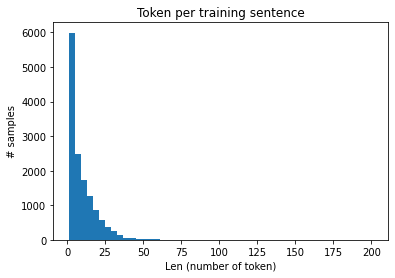

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

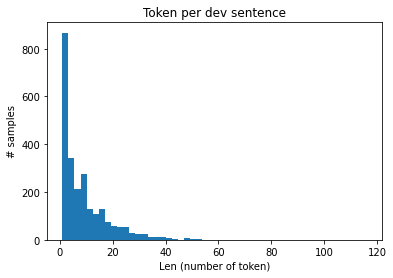

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

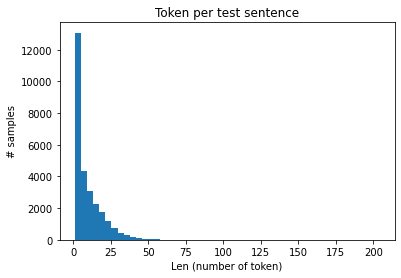

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

10622
PC
3
I-problem


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9892)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13867
Points in y_train before removal: 13867
Points in X_train before removal: 150
Points in y_train before removal: 150


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[23137, 3560, 3505]
[2, 2, 2]
[22719, 23699, 24074, 25353, 9478, 8313, 28380, 3668, 13113, 8739, 25679, 15981]
[7, 4, 4, 4, 4, 4, 2, 5, 6, 6, 6, 2]
[20937, 23638, 22989]
[2, 2, 2]
10622
3
O
blowing
28388
7


In [ ]:
# # Uncomment this cell if you want to load saved data

# # Re-import necessary libs
# import pandas as pd
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# import pickle, math
# from requests import get
# import numpy as np
# import matplotlib.pyplot as plt
# import random
# %tensorflow_version 2.x
# from keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
# from keras.models import Model, Sequential
# from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# from tensorflow.keras.optimizers import Adam
# import keras as k
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# import matplotlib.pyplot as plt
# !pip install seqeval
# from seqeval.metrics import f1_score, classification_report
# !pip install tensorflow-addons
# import tensorflow.keras.backend as K
# import tensorflow.keras.layers as L
# from tensorflow_addons.text import crf_log_likelihood, crf_decode

# BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
# notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

# X_train_filename = f'{notebook_filename}_X_train.csv'
# y_train_filename = f'{notebook_filename}_y_train.csv'
# X_dev_filename = f'{notebook_filename}_X_dev.csv'
# y_dev_filename = f'{notebook_filename}_y_dev.csv'
# X_test_filename = f'{notebook_filename}_X_test.csv'
# y_test_filename = f'{notebook_filename}_y_test.csv'

# word2idx_filename = f'{notebook_filename}_word2idx.pkl'
# idx2word_filename = f'{notebook_filename}_idx2word.pkl'
# tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
# idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

# others_filename = f'{notebook_filename}_others.pkl'

# # Re-get important variables
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# def get_backup_files_ids(folder_id):
#   file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
#   return file_list

# def load_backup_dataset(file_id):
#   downloaded = drive.CreateFile({'id':file_id})
#   downloaded.GetContentFile(f"{file_id}.csv")

#   dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
#   dataset = dataset.fillna(method="ffill")
#   dataset = dataset.values.tolist()
#   dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
#   return dataset

# def load_backup_dict(file_id):
#   downloaded = drive.CreateFile({'id':file_id})
#   downloaded.GetContentFile(f"{file_id}.pkl")

#   dict_file = open(f"{file_id}.pkl", "rb")
#   out_dict = pickle.load(dict_file)
#   return out_dict

# backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

# X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
# y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
# X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
# y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
# X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
# y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

# word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
# idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
# tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
# idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

# others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

# X_train = load_backup_dataset(X_train_file_id)
# y_train = load_backup_dataset(y_train_file_id)
# X_dev = load_backup_dataset(X_dev_file_id)
# y_dev = load_backup_dataset(y_dev_file_id)
# X_test = load_backup_dataset(X_test_file_id)
# y_test = load_backup_dataset(y_test_file_id)

# word2idx = load_backup_dict(word2idx_file_id)
# idx2word = load_backup_dict(idx2word_file_id)
# tag2idx = load_backup_dict(tag2idx_file_id)
# idx2tag = load_backup_dict(idx2tag_file_id)

# others = load_backup_dict(others_file_id)

# n_words = others["n_words"]
# n_tags = others["n_tags"]

# # Check some points after loading data to see if they match the ones before saving
# print(X_train[0])
# print(y_train[0])
# print(X_dev[0])
# print(y_dev[0])
# print(X_test[0])
# print(y_test[0])
# print(word2idx['comprehension'])
# print(tag2idx['B-treatment'])
# print(idx2tag[2])
# print(idx2word[100])
# print(n_words)
# print(n_tags)

In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-08-02 07:01:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-02 07:01:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-02 07:01:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = n_words + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10358 words (18031 misses)


In [ ]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [ ]:
# Model creation function
def create_model(maxlen, n_words):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+2, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=100, return_sequences=True, 
                              recurrent_dropout = 0,
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags+1, activation='relu')))
    crf = CRF(n_tags+1, sparse_target=True)
    model.add(crf)
    # adam = Adam()
    model.compile(optimizer='adam', loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [ ]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 512:
    batch_size = 512
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [ ]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [ ]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["PAD"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["PAD"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["PAD"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags+1) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags+1) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags+1) for i in new_y_test]

  model = None
  model = create_model(maxlen, n_words)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          2839000   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 8)           1608      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 8)            64        
                                                                 
Total params: 3,001,472
Trai

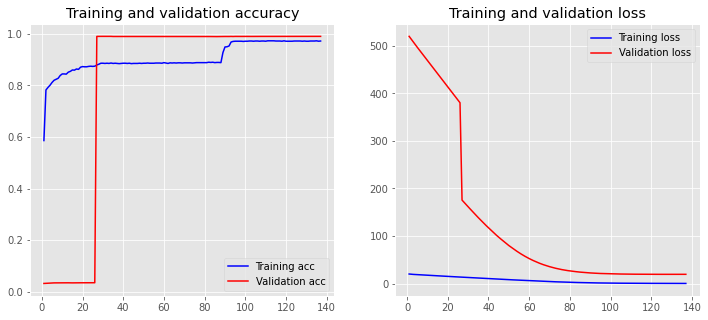

864/864 [==============================] - 75s 84ms/step


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


F1-score: 53.2%
Classification Report:
,precision,recall,f1-score,support
AD,0.838837468937948,0.8431798436142485,0.8410030510371721,27624.0
problem,0.3093577367334412,0.44171779141104295,0.36387503281701233,12551.0
test,0.08753907994640464,0.04349755881047492,0.058117123795404,9012.0
treatment,0.22136669874879691,0.1728024042073629,0.1940928270042194,9317.0
micro avg,0.5368826058949494,0.5271092574866676,0.5319510449099989,58504.0
macro avg,0.3642752460916477,0.3752993995107823,0.36427200866345194,58504.0
weighted avg,0.5111816442705257,0.5271092574866676,0.5150242412070911,58504.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 204, 100)          2839000   
                                                                 
 

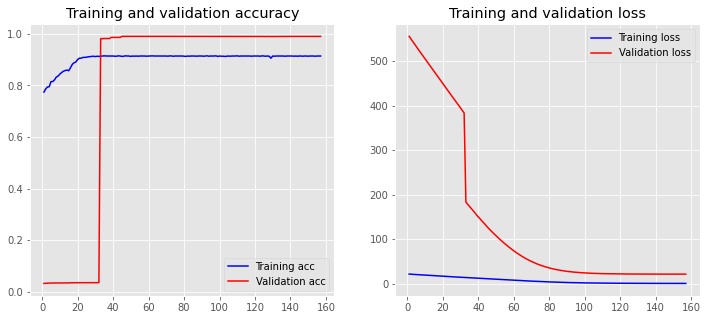

864/864 [==============================] - 76s 85ms/step
F1-score: 54.4%
Classification Report:
,precision,recall,f1-score,support
AD,0.8452466561196605,0.8509991311902694,0.8481131394761526,27624.0
problem,0.27139917695473254,0.31527368337184286,0.2916958460801297,12551.0
test,0.2912018255578093,0.25488237905015537,0.27183431952662723,9012.0
treatment,0.2469703301295445,0.19029730599978534,0.2149612027158099,9317.0
micro avg,0.5488261194939,0.5390229727881855,0.5438803756370567,58504.0
macro avg,0.4137044971904367,0.40286312490301324,0.40665112694967986,58504.0
weighted avg,0.5415143941671047,0.5390229727881855,0.5391411927785812,58504.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 204, 100)          2839000   
          

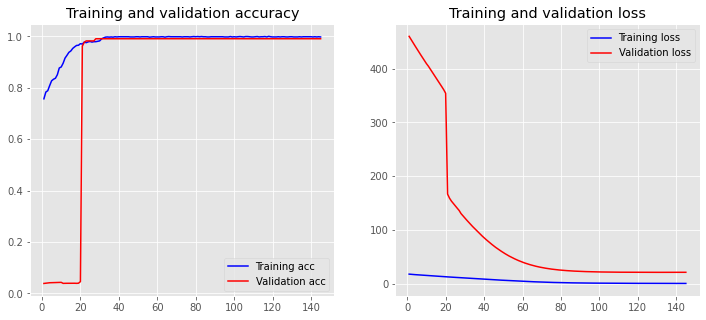

864/864 [==============================] - 75s 84ms/step
F1-score: 58.6%
Classification Report:
,precision,recall,f1-score,support
AD,0.8764118158123371,0.8764118158123371,0.8764118158123371,27624.0
problem,0.3281584930172134,0.4025177276711019,0.3615544263937594,12551.0
test,0.38783412440669496,0.3445406125166445,0.36490774474086257,9012.0
treatment,0.23749769330134712,0.1381345926800472,0.17467426710097722,9317.0
micro avg,0.5962369782439232,0.5752427184466019,0.5855517277377598,58504.0
macro avg,0.45747553163439814,0.4404011871700326,0.4443870635119841,58504.0
weighted avg,0.5817832008666215,0.5752427184466019,0.575411225691449,58504.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 204, 100)          2839000   
          

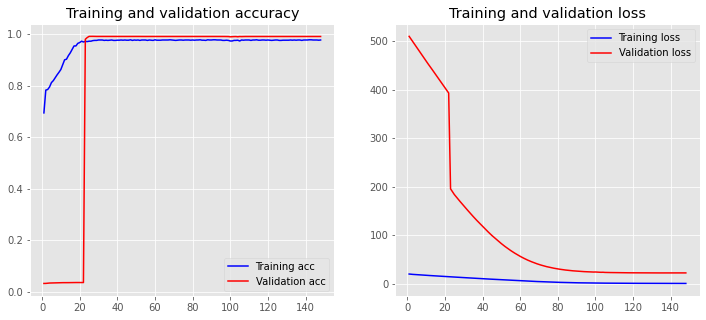

864/864 [==============================] - 75s 84ms/step
F1-score: 56.9%
Classification Report:
,precision,recall,f1-score,support
AD,0.8666954426099781,0.8722487691862149,0.8694632386107352,27624.0
problem,0.3039472917031077,0.4153453908055135,0.3510201333243553,12551.0
test,0.3030174245643859,0.23735019973368843,0.2661937651670711,9012.0
treatment,0.2813148236795915,0.18922399914135452,0.2262577002053388,9317.0
micro avg,0.5698548337279934,0.5676534937782032,0.5687520337038242,58504.0
macro avg,0.4387437456392658,0.42854208971669283,0.4282337093268751,58504.0
weighted avg,0.5659141359090103,0.5676534937782032,0.5628792458846525,58504.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 204, 100)          2839000   
           

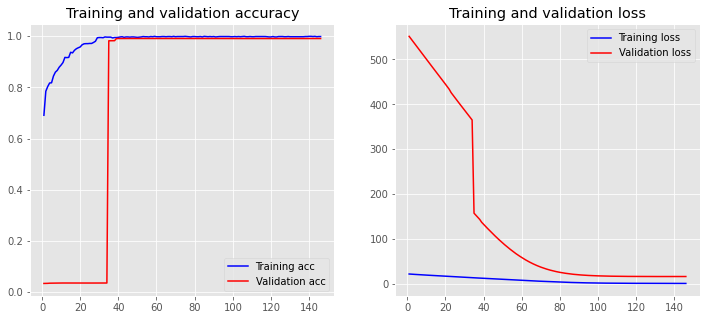

864/864 [==============================] - 76s 85ms/step
F1-score: 58.0%
Classification Report:
,precision,recall,f1-score,support
AD,0.8772806255430061,0.8772806255430061,0.8772806255430061,27624.0
problem,0.3154803259015979,0.3979762568719624,0.35195885005636973,12551.0
test,0.3432147562582345,0.2890590324012428,0.31381761233586314,9012.0
treatment,0.2752109280835677,0.14704303960502307,0.19167541098286112,9317.0
micro avg,0.5926639892904954,0.5675509366880898,0.579835674807254,58504.0
macro avg,0.4527966589466016,0.4278397386053086,0.433683124729525,58504.0
weighted avg,0.5786063375281136,0.5675509366880898,0.5686004316551964,58504.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 204, 100)          2839000   
            

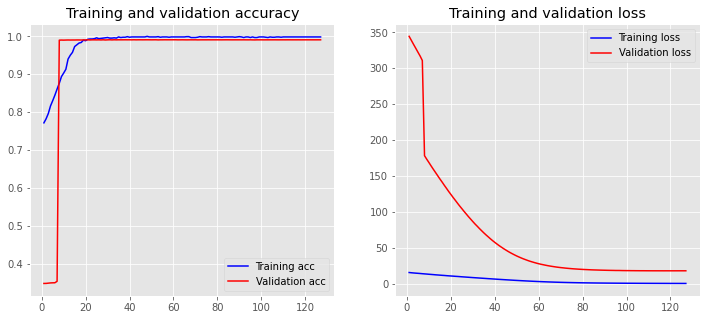

864/864 [==============================] - 74s 83ms/step
F1-score: 58.4%
Classification Report:
,precision,recall,f1-score,support
AD,0.8803981900452489,0.8804300608166812,0.8804141251425366,27624.0
problem,0.317225731281045,0.4121583937534858,0.35851410354147895,12551.0
test,0.38803854875283444,0.30381713271193966,0.34080159322877773,9012.0
treatment,0.25082911502880084,0.1542341955565096,0.19101422304931545,9317.0
micro avg,0.5936315390447309,0.5754991111718857,0.5844247142447991,58504.0
macro avg,0.4591228962769823,0.43765994570965405,0.4426860112405272,58504.0
weighted avg,0.5834746003897551,0.5754991111718857,0.5755376347055715,58504.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 204, 100)          2839000   
        

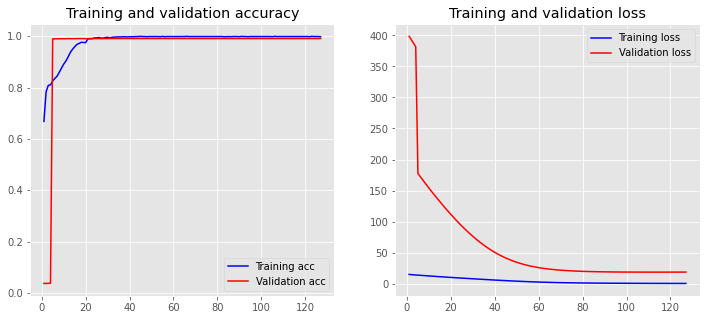

864/864 [==============================] - 75s 84ms/step
F1-score: 58.3%
Classification Report:
,precision,recall,f1-score,support
AD,0.8734433825658847,0.8734433825658847,0.8734433825658847,27624.0
problem,0.3093169201062032,0.4084136722173532,0.35202417333379116,12551.0
test,0.364713216957606,0.32456724367509987,0.34347111319868484,9012.0
treatment,0.31759455015268967,0.1451110872598476,0.19920436127891558,9317.0
micro avg,0.5937527668089175,0.5731402980992752,0.5832644789827531,58504.0
macro avg,0.46626701744559584,0.43788384642954636,0.4420357575943191,58504.0
weighted avg,0.5855336489684041,0.5731402980992752,0.5725694671423255,58504.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 204, 100)          2839000   
        

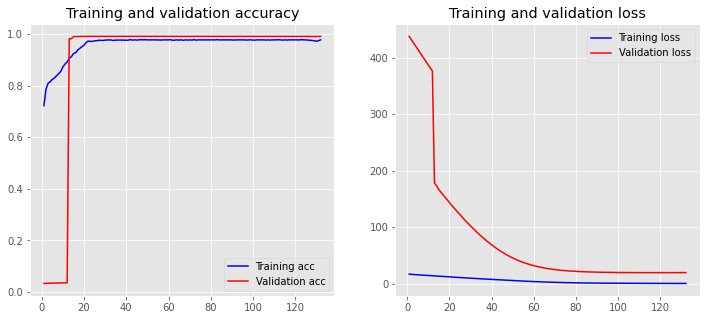

864/864 [==============================] - 75s 84ms/step
F1-score: 56.3%
Classification Report:
,precision,recall,f1-score,support
AD,0.8696185187856061,0.8730813785114393,0.8713465081830991,27624.0
problem,0.32470501019336506,0.4187714126364433,0.3657874591133691,12551.0
test,0.3008613617719442,0.16278295605858856,0.2112615207373272,9012.0
treatment,0.19694019471488178,0.15198025115380487,0.17156357908765976,9317.0
micro avg,0.576151606622966,0.5513640092985095,0.5634853394589968,58504.0
macro avg,0.42303127136644925,0.401653999590069,0.4049897667803638,58504.0
weighted avg,0.5579784105756499,0.5513640092985095,0.5497644782002316,58504.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 204, 100)          2839000   
          

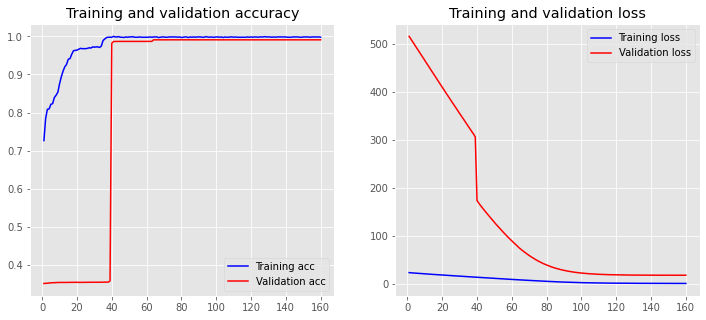

864/864 [==============================] - 75s 84ms/step
F1-score: 59.5%
Classification Report:
,precision,recall,f1-score,support
AD,0.876339415001448,0.876339415001448,0.8763394150014479,27624.0
problem,0.33513312232358966,0.43024460202374315,0.37677923527770024,12551.0
test,0.4103016924208977,0.3093652907234798,0.35275510849623587,9012.0
treatment,0.3056251423365976,0.14403778040141677,0.19579807411730377,9317.0
micro avg,0.6142781712579429,0.5766785177081909,0.5948848157846016,58504.0
macro avg,0.4818498430206333,0.4399967720375219,0.45041795822317193,58504.0
weighted avg,0.5975557931343256,0.5766785177081909,0.58013530487299,58504.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 204, 100)          2839000   
          

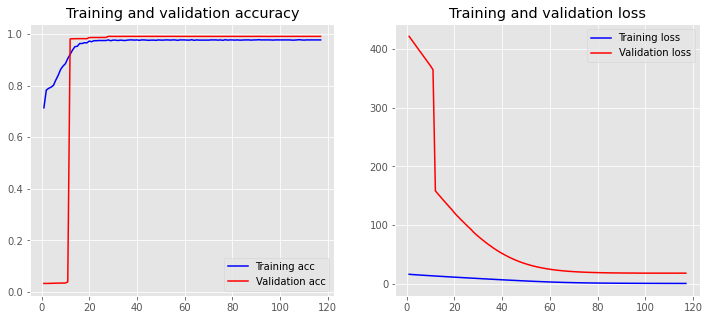

864/864 [==============================] - 73s 82ms/step
F1-score: 56.2%
Classification Report:
,precision,recall,f1-score,support
AD,0.8728442821504754,0.8739501882421084,0.8733968851183909,27624.0
problem,0.2817610744070183,0.4145486415425066,0.3354934390817939,12551.0
test,0.29081472161056937,0.20517088326675545,0.24059856864020823,9012.0
treatment,0.27499516534519436,0.15262423526886337,0.19630038652678078,9317.0
micro avg,0.5657196378395254,0.5575003418569671,0.5615799170095903,58504.0
macro avg,0.43010381087831434,0.4115734870800584,0.4114473198417934,58504.0
weighted avg,0.56117164504449,0.5575003418569671,0.5526921015705182,58504.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 204, 100)          2839000   
                                                                 
 bidirectional_10 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 204, 8)           1608      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 204, 8)            64        
                                                                 
Total params: 3,001,47

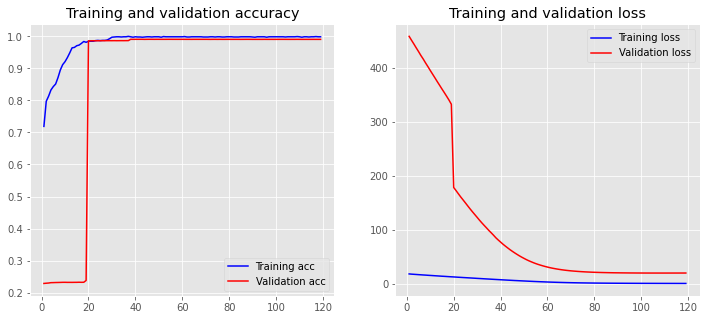

864/864 [==============================] - 70s 78ms/step


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


F1-score: 57.5%
Classification Report:
,precision,recall,f1-score,support
AD,0.8769999276044306,0.8770634231103388,0.8770316742081448,27624.0
problem,0.3026218154835518,0.3899290893155924,0.34077220346064124,12551.0
test,0.3911417888984757,0.3018197958277852,0.3407240385819867,9012.0
treatment,0.21814553269880257,0.15251690458302028,0.1795211925968037,9317.0
micro avg,0.5808507665979814,0.5685594147408725,0.5746393711669691,58504.0
macro avg,0.44722726617131514,0.43033230320918414,0.4345122772118941,58504.0
weighted avg,0.5740100529192305,0.5685594147408725,0.5682920634672088,58504.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 204, 100)          2839000   
                                                                 

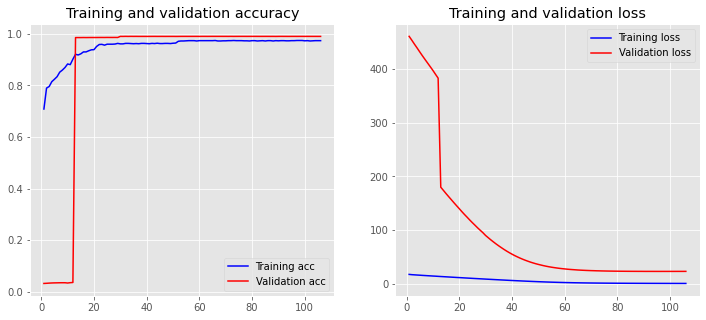

864/864 [==============================] - 70s 78ms/step
F1-score: 55.2%
Classification Report:
,precision,recall,f1-score,support
AD,0.8541561712846347,0.8592890240370692,0.8567149095896345,27624.0
problem,0.2878061356019593,0.4447454386104693,0.34946472171789894,12551.0
test,0.251702786377709,0.09021304926764315,0.1328214344061428,9012.0
treatment,0.26641980120834147,0.14672104754749382,0.18923034330011074,9317.0
micro avg,0.567079537680481,0.5384076302475045,0.552371766768961,58504.0
macro avg,0.41502122361816113,0.38524213986566885,0.3820578522534468,58504.0
weighted avg,0.5462539942944238,0.5384076302475045,0.5300846140465728,58504.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 204, 100)          2839000   
         

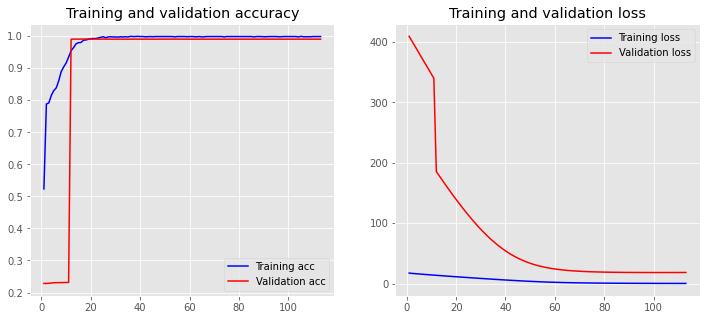

864/864 [==============================] - 70s 79ms/step
F1-score: 58.4%
Classification Report:
,precision,recall,f1-score,support
AD,0.8777238832983422,0.8777874312192296,0.8777556561085973,27624.0
problem,0.3114220007665772,0.3884152657158792,0.34568338946995214,12551.0
test,0.38626492942453855,0.3158011540168664,0.34749694749694754,9012.0
treatment,0.2662708883025506,0.12997746055597295,0.17468445726649837,9317.0
micro avg,0.601130516704109,0.5671407083276357,0.5836411609498682,58504.0
macro avg,0.46042042544800216,0.427995327876987,0.4364051125854988,58504.0
weighted avg,0.5831527330463475,0.5671407083276357,0.5699605504713476,58504.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 204, 100)          2839000   
         

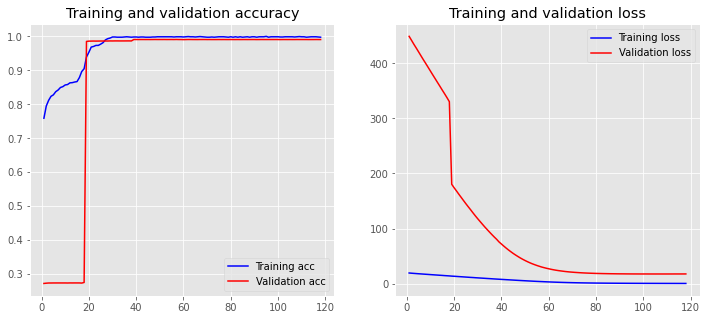

864/864 [==============================] - 71s 79ms/step
F1-score: 58.2%
Classification Report:
,precision,recall,f1-score,support
AD,0.8768100202722271,0.8768100202722271,0.8768100202722271,27624.0
problem,0.30871255431054195,0.43024460202374315,0.35948473854142393,12551.0
test,0.35680534747032383,0.34354194407456723,0.350048052461982,9012.0
treatment,0.28650442477876104,0.16679188580015025,0.2108405128553015,9317.0
micro avg,0.5787358359930426,0.5857890058799399,0.5822410614928517,58504.0
macro avg,0.45720808670796353,0.45434711304267195,0.44929583103273363,58504.0
weighted avg,0.5808242647719453,0.5857890058799399,0.5786258556764262,58504.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 204, 100)          2839000   
    

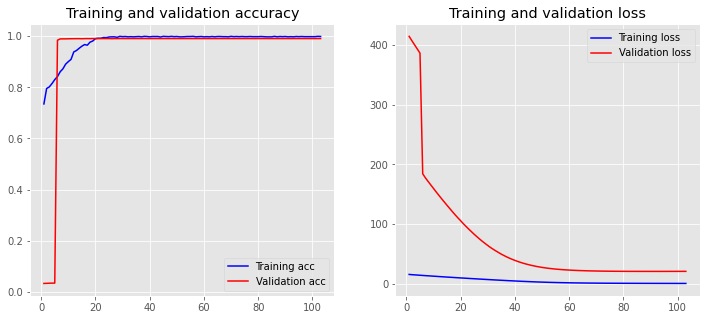

864/864 [==============================] - 72s 80ms/step
F1-score: 57.4%
Classification Report:
,precision,recall,f1-score,support
AD,0.8783030478534714,0.8783666377063423,0.8783348416289593,27624.0
problem,0.3017376576124459,0.38323639550633415,0.3376386354064299,12551.0
test,0.33895520753477165,0.34343098091433644,0.3411784159179849,9012.0
treatment,0.24289749127762086,0.15691746270258666,0.1906624934793949,9317.0
micro avg,0.5727642761040244,0.5748495829345002,0.5738050349340135,58504.0
macro avg,0.44047335106957747,0.44048786920739985,0.4369535966081922,58504.0
weighted avg,0.5703386604528761,0.5748495829345002,0.570079422161645,58504.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 204, 100)          2839000   
       

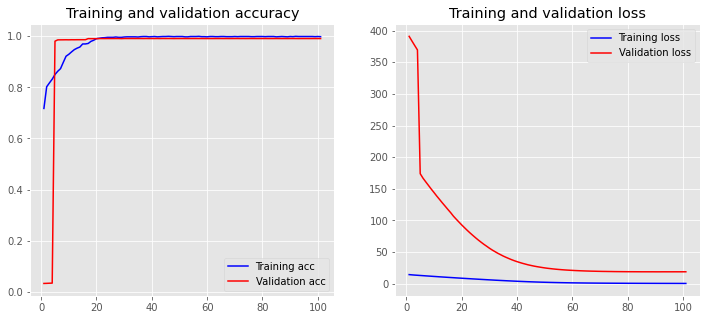

864/864 [==============================] - 69s 77ms/step
F1-score: 58.9%
Classification Report:
,precision,recall,f1-score,support
AD,0.8830407239819005,0.8830726904141326,0.8830567069087223,27624.0
problem,0.3066216786166175,0.40546569994422754,0.34918347742555234,12551.0
test,0.38008361839604715,0.33288948069241014,0.354924578527063,9012.0
treatment,0.31087036356959236,0.18171085113233873,0.22935717672559777,9317.0
micro avg,0.5937353416375671,0.5841651852864761,0.5889113858613708,58504.0
macro avg,0.47015409614103937,0.45078468054577725,0.4541304848967338,58504.0
weighted avg,0.590783850573572,0.5841651852864761,0.583065455593685,58504.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 204, 100)          2839000   
       

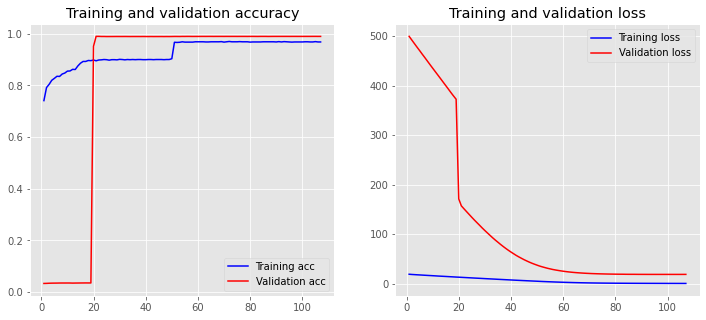

864/864 [==============================] - 67s 75ms/step
F1-score: 54.7%
Classification Report:
,precision,recall,f1-score,support
AD,0.8589702014196663,0.8629814653924124,0.8609711613124582,27624.0
problem,0.26674870785134136,0.4317584256234563,0.32976328120245846,12551.0
test,0.2855335301560523,0.22536617842876164,0.25190697674418605,9012.0
treatment,0.228820429671666,0.12117634431684018,0.1584450214020069,9317.0
micro avg,0.5392664060550612,0.5541159578832217,0.5465903438740843,58504.0
macro avg,0.41001821727468146,0.41032060344036764,0.40027161016527735,58504.0
weighted avg,0.5432330095938108,0.5541159578832217,0.5413090428225165,58504.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 204, 100)          2839000   
      

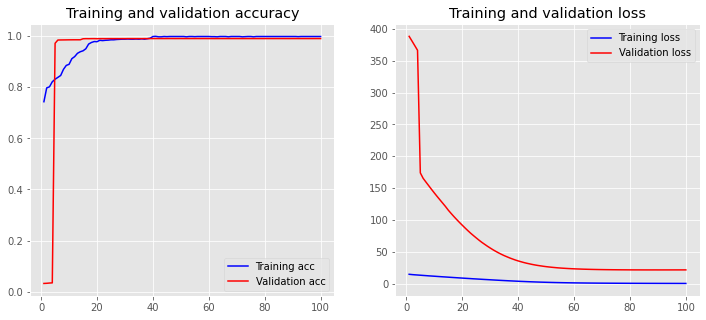

864/864 [==============================] - 71s 79ms/step
F1-score: 57.6%
Classification Report:
,precision,recall,f1-score,support
AD,0.8705111497248769,0.8705111497248769,0.8705111497248769,27624.0
problem,0.3116549000837621,0.4150266911003107,0.35598838202631133,12551.0
test,0.35920622959055515,0.31735463826009763,0.33698597855543777,9012.0
treatment,0.25678927466483326,0.16035204464956532,0.19742319127849356,9317.0
micro avg,0.5783062046181906,0.574490633119103,0.5763921044056868,58504.0
macro avg,0.44954038851600686,0.4408111309337126,0.44022717539627987,58504.0
weighted avg,0.5741189126226178,0.574490633119103,0.5707527638229106,58504.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 204, 100)          2839000   
      

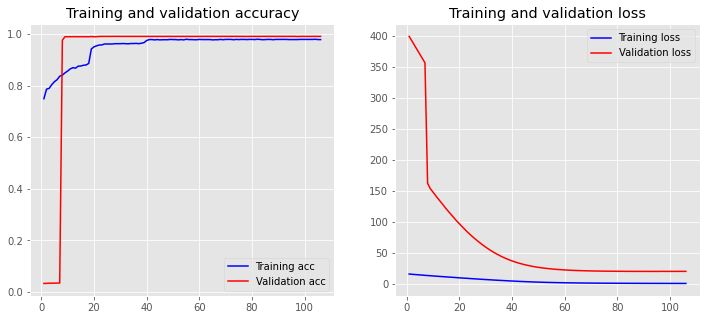

864/864 [==============================] - 70s 79ms/step
F1-score: 56.4%
Classification Report:
,precision,recall,f1-score,support
AD,0.8748241912798875,0.8781494352736751,0.8764836594222535,27624.0
problem,0.2817029469968444,0.41964783682575096,0.3371095750128008,12551.0
test,0.32067851373182554,0.2643142476697736,0.28978102189781024,9012.0
treatment,0.2409502262443439,0.13716861650745948,0.17481704397784006,9317.0
micro avg,0.5609554075526556,0.567226172569397,0.5640733626829393,58504.0
macro avg,0.42953896956322535,0.42482003406916474,0.4195478250776762,58504.0
weighted avg,0.5612724800243192,0.567226172569397,0.558651098248848,58504.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 204, 100)          2839000   
        

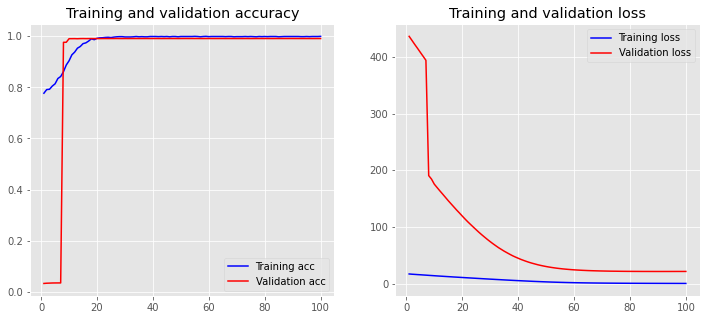

864/864 [==============================] - 69s 77ms/step
F1-score: 58.6%
Classification Report:
,precision,recall,f1-score,support
AD,0.882863968725114,0.8829278887923545,0.8828959276018099,27624.0
problem,0.32304794075613874,0.39622340849334714,0.3559134013240293,12551.0
test,0.4163500589545395,0.3526409232134931,0.38185641333733855,9012.0
treatment,0.21775898520084566,0.16582590962756252,0.18827687058250062,9317.0
micro avg,0.5902542079379373,0.5826268289347737,0.5864157175790523,58504.0
macro avg,0.46000523840915947,0.44940453253168927,0.4522356532114196,58504.0
weighted avg,0.5849824998787679,0.5826268289347737,0.5820397204345609,58504.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 204, 100)          2839000   
                                                                 
 bidirectional_20 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 204, 8)           1608      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 204, 8)            64        
                                                                 
Total params: 3,001,47

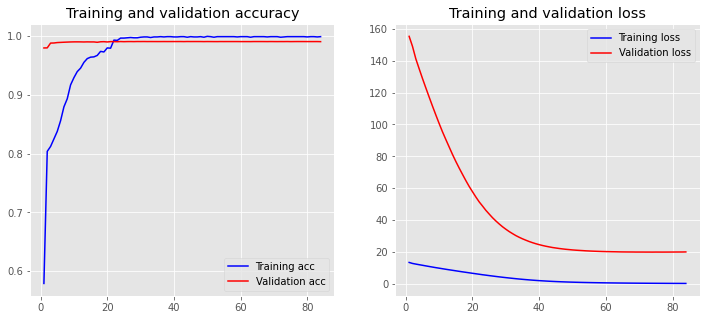

864/864 [==============================] - 69s 77ms/step


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


F1-score: 58.1%
Classification Report:
,precision,recall,f1-score,support
AD,0.8696785403996524,0.8696785403996524,0.8696785403996524,27624.0
problem,0.3152897060602395,0.4153453908055135,0.35846656352071515,12551.0
test,0.42545558903716457,0.329005770084332,0.37106564044803203,9012.0
treatment,0.2026452527161077,0.09208972845336481,0.1266327208324109,9317.0
micro avg,0.5971712938711368,0.5650895665253658,0.5806876564352523,58504.0
macro avg,0.45326727205329104,0.4265298574357157,0.43146086630020264,58504.0
weighted avg,0.5760880057555205,0.5650895665253658,0.5648672646393706,58504.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 204, 100)          2839000   
                                                                 

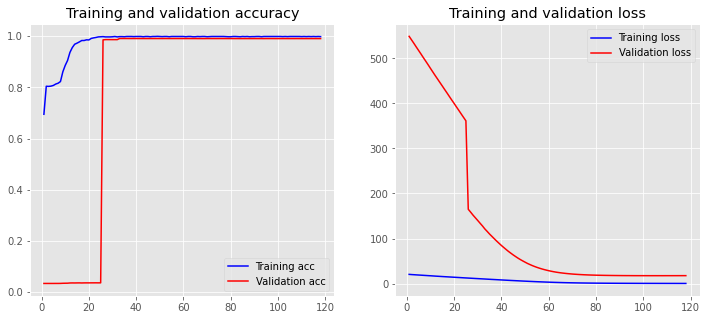

864/864 [==============================] - 67s 75ms/step
F1-score: 58.1%
Classification Report:
,precision,recall,f1-score,support
AD,0.8792398190045249,0.8792716478424558,0.8792557331354414,27624.0
problem,0.3023848534498453,0.3970201577563541,0.34330003444712365,12551.0
test,0.38970809509479387,0.28739458499778076,0.33082130540298893,9012.0
treatment,0.26321709786276715,0.1506922829236879,0.19165927240461403,9317.0
micro avg,0.5931459952927751,0.5686106932859292,0.5806192620518728,58504.0
macro avg,0.45863746635298286,0.42859466838006965,0.43625908634754196,58504.0
weighted avg,0.5819738156299004,0.5686106932859292,0.5702921193382471,58504.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 204, 100)          2839000   
    

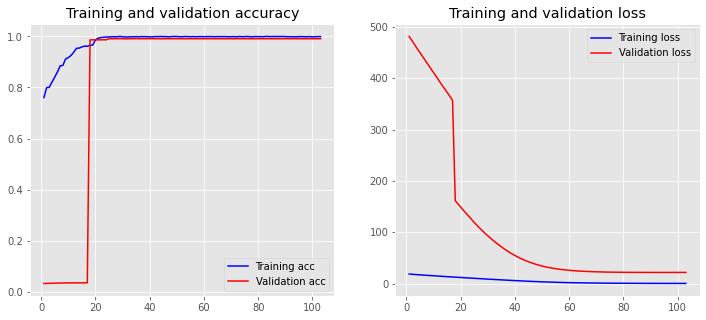

864/864 [==============================] - 67s 75ms/step
F1-score: 58.4%
Classification Report:
,precision,recall,f1-score,support
AD,0.8734525447042641,0.8735157833767738,0.8734841628959277,27624.0
problem,0.30071834086432625,0.41359254242689825,0.348237346124174,12551.0
test,0.4358564579398518,0.33288948069241014,0.3774771940861906,9012.0
treatment,0.27059530968129886,0.14489642588816143,0.18873200055920591,9317.0
micro avg,0.5932170542635659,0.5755332968685902,0.5842413936701834,58504.0
macro avg,0.4701556632974353,0.44122355809606084,0.44698267591637453,58504.0
weighted avg,0.5871674396682852,0.5755332968685902,0.5753468817406755,58504.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 204, 100)          2839000   
      

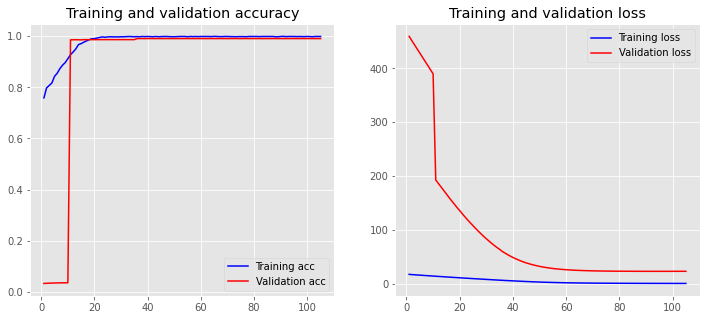

864/864 [==============================] - 69s 77ms/step
F1-score: 58.1%
Classification Report:
,precision,recall,f1-score,support
AD,0.8763800904977376,0.8764118158123371,0.8763959528679252,27624.0
problem,0.299816606589515,0.37773882559158634,0.3342969961923566,12551.0
test,0.37725129940771185,0.3463160230803373,0.36112236042811685,9012.0
treatment,0.28272576636288316,0.14650638617580766,0.19300106044538706,9317.0
micro avg,0.5913970887352094,0.5715335703541639,0.5812956894378625,58504.0
macro avg,0.4590434407144619,0.43674326266501706,0.44120409248344644,58504.0
weighted avg,0.581260538162857,0.5715335703541639,0.5718916483245878,58504.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 204, 100)          2839000   
       

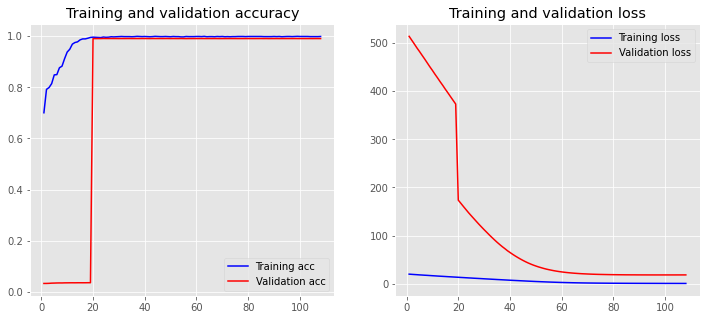

864/864 [==============================] - 70s 79ms/step
F1-score: 58.3%
Classification Report:
,precision,recall,f1-score,support
AD,0.8833984940631335,0.8833984940631335,0.8833984940631335,27624.0
problem,0.3122052789515586,0.4061827742809338,0.3530470914127424,12551.0
test,0.3735518508053122,0.2933865956502441,0.32865133623368553,9012.0
treatment,0.2590492076730609,0.1666845551143072,0.20284743991640544,9317.0
micro avg,0.5909234384315926,0.575994803774101,0.5833636284947632,58504.0
macro avg,0.45705120787326625,0.43741310477715467,0.4419860904064918,58504.0
weighted avg,0.5828917544692397,0.575994803774101,0.5757867749924869,58504.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 204, 100)          2839000   
           

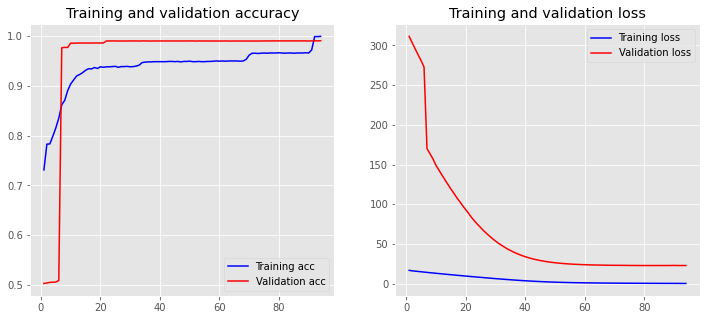

864/864 [==============================] - 70s 79ms/step
F1-score: 52.3%
Classification Report:
,precision,recall,f1-score,support
AD,0.840296423585007,0.8496959165942659,0.8449700307791997,27624.0
problem,0.24416392073142432,0.4191697872679468,0.30858114845445483,12551.0
test,0.15421303656597773,0.06458055925432757,0.09103707179727827,9012.0
treatment,0.23491329479768785,0.10904797681657186,0.1489517666031374,9317.0
micro avg,0.5267719133711943,0.5184431833720772,0.5225743648940845,58504.0
macro avg,0.3683966689200242,0.360623559983278,0.34838500440851755,58504.0
weighted avg,0.5103121979245007,0.5184431833720772,0.5029171308795122,58504.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 204, 100)          2839000   
       

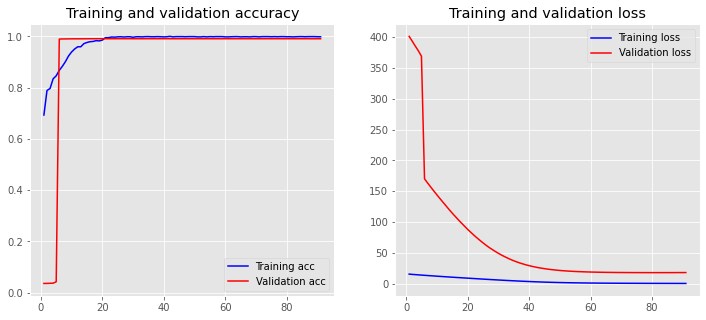

864/864 [==============================] - 70s 78ms/step
F1-score: 58.0%
Classification Report:
,precision,recall,f1-score,support
AD,0.8799362942049445,0.8800318563567912,0.8799840726864672,27624.0
problem,0.30057949105568155,0.3802087483069078,0.3357371512998206,12551.0
test,0.38709223847019125,0.30548158011540166,0.3414785413048871,9012.0
treatment,0.24310915104740904,0.0946656649135988,0.13626882966396292,9317.0
micro avg,0.6031561676160979,0.5592267195405443,0.5803613399913079,58504.0
macro avg,0.45267929369455656,0.41509696242317484,0.42336714873878445,58504.0
weighted avg,0.5783101428408197,0.5592267195405443,0.5618340337425441,58504.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 204, 100)          2839000   
     

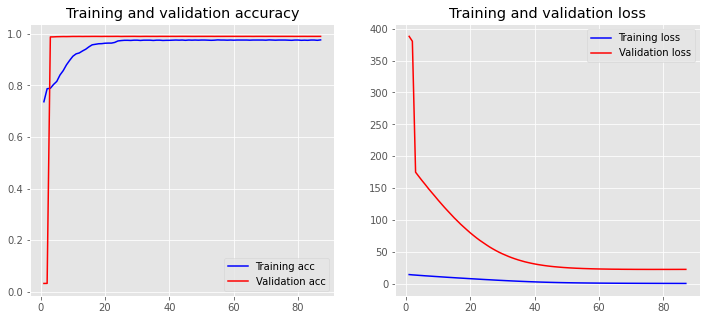

864/864 [==============================] - 71s 80ms/step
F1-score: 56.0%
Classification Report:
,precision,recall,f1-score,support
AD,0.8702408422267089,0.8737691862148856,0.8720014450867052,27624.0
problem,0.2951500387553981,0.4247470321089953,0.3482834090092444,12551.0
test,0.2916906267970098,0.22514425210830005,0.2541332665330661,9012.0
treatment,0.2132132132132132,0.1143071804228829,0.14882615986584685,9317.0
micro avg,0.5638539195483905,0.5565773280459456,0.5601919950452893,58504.0
macro avg,0.4175736802480825,0.40949191271376595,0.40581107012371564,58504.0
weighted avg,0.5531106351410462,0.5565773280459456,0.5493015061366106,58504.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 204, 100)          2839000   
         

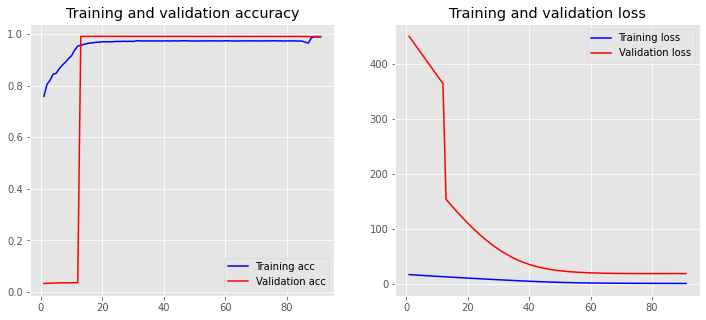

864/864 [==============================] - 71s 79ms/step
F1-score: 58.3%
Classification Report:
,precision,recall,f1-score,support
AD,0.8664240415105218,0.8704387489139879,0.8684267552730425,27624.0
problem,0.3208012512030799,0.4249063819615967,0.3655869751499572,12551.0
test,0.37157908261595785,0.3209054593874834,0.344388210777017,9012.0
treatment,0.3877551020408163,0.002039283031018568,0.004057228272474909,9317.0
micro avg,0.6184684339564818,0.5519109804457815,0.5832972035551702,58504.0
macro avg,0.4866398693425939,0.4045724683235216,0.39561479236812286,58504.0
weighted avg,0.5969140435660092,0.5519109804457815,0.542173707167147,58504.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 204, 100)          2839000   
        

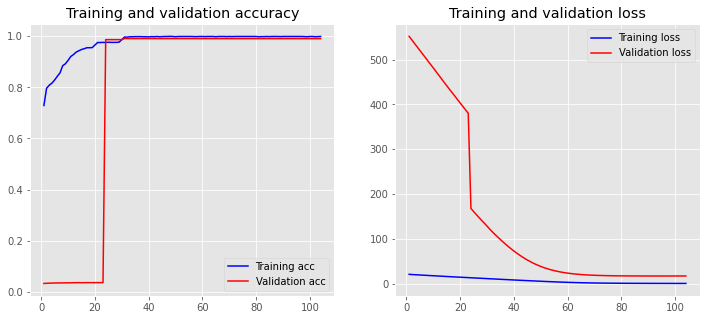

864/864 [==============================] - 70s 79ms/step
F1-score: 58.1%
Classification Report:
,precision,recall,f1-score,support
AD,0.8772444251375615,0.8772444251375615,0.8772444251375615,27624.0
problem,0.3053329489766503,0.42195840968847104,0.35429488894835426,12551.0
test,0.41695652173913045,0.31924101198402133,0.36161387631975866,9012.0
treatment,0.22455365359838028,0.1309434367285607,0.16542372881355932,9317.0
micro avg,0.5868207043384175,0.5747641186927389,0.580729841286289,58504.0
macro avg,0.45602188736293064,0.4373468208846536,0.43964422980480844,58504.0
weighted avg,0.5797041639391339,0.5747641186927389,0.5722663798362573,58504.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 204, 100)          2839000   
                                                                 
 bidirectional_30 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 204, 8)           1608      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 204, 8)            64        
                                                                 
Total params: 3,001,47

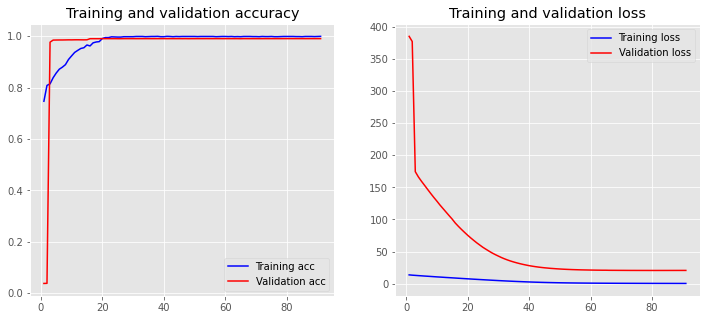

864/864 [==============================] - 70s 78ms/step


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


F1-score: 57.3%
Classification Report:
,precision,recall,f1-score,support
AD,0.8741403026134801,0.87420359108022,0.8741719457013574,27624.0
problem,0.30145194745333026,0.41685921440522666,0.3498846423914134,12551.0
test,0.3708211143695015,0.28062583222370174,0.3194795351187469,9012.0
treatment,0.22873688020267824,0.13566598690565632,0.17031597385973185,9317.0
micro avg,0.5786701088473346,0.5670381512375222,0.5727950825333241,58504.0
macro avg,0.4437875611597475,0.4268386561537012,0.42846302426781235,58504.0
weighted avg,0.5709653443769285,0.5670381512375222,0.564158202407531,58504.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 204, 100)          2839000   
                                                                 


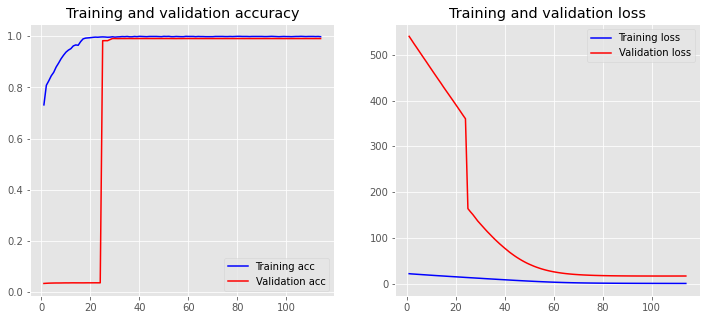

864/864 [==============================] - 70s 79ms/step
F1-score: 58.7%
Classification Report:
,precision,recall,f1-score,support
AD,0.8808006949974662,0.8808644656820156,0.8808325791855204,27624.0
problem,0.3229941842286286,0.41152099434308026,0.3619227804638778,12551.0
test,0.37291527685123416,0.31014203284509545,0.3386442115466166,9012.0
treatment,0.2664963814389102,0.13437801867553933,0.1786657153050303,9317.0
micro avg,0.6010571582153736,0.5733795979762067,0.586892244169568,58504.0
macro avg,0.46080163437905985,0.4342263778864327,0.4400163216252613,58504.0
weighted avg,0.5850676477798642,0.5733795979762067,0.57416761399183,58504.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 204, 100)          2839000   
           

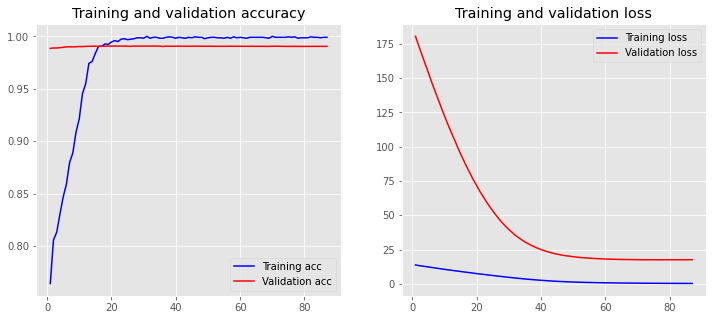

864/864 [==============================] - 71s 79ms/step
F1-score: 57.1%
Classification Report:
,precision,recall,f1-score,support
AD,0.8780134655759068,0.878077034462786,0.8780452488687783,27624.0
problem,0.29557962009586364,0.3979762568719624,0.3392190152801358,12551.0
test,0.3131544108797689,0.2887261429205504,0.30044454708157725,9012.0
treatment,0.27161997563946405,0.11967371471503703,0.16614513485322605,9317.0
micro avg,0.5790056024868719,0.5635170244769588,0.5711563282312484,58504.0
macro avg,0.43959186804775086,0.42111328724258396,0.4209634865209294,58504.0
weighted avg,0.5694806277993538,0.5635170244769588,0.5601025621369273,58504.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 204, 100)          2839000   
       

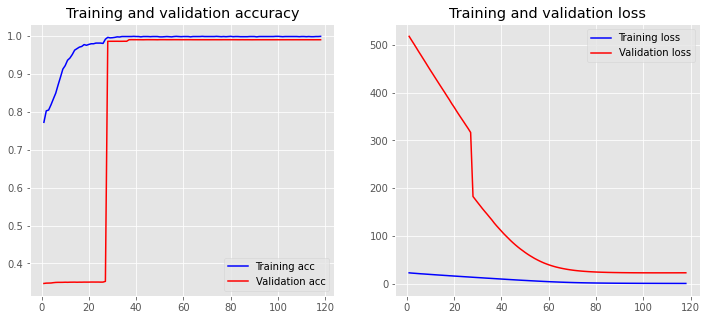

864/864 [==============================] - 71s 79ms/step
F1-score: 58.2%
Classification Report:
,precision,recall,f1-score,support
AD,0.8786924413553432,0.8786924413553432,0.8786924413553432,27624.0
problem,0.3061664510564899,0.39598438371444505,0.34533073929961094,12551.0
test,0.394919168591224,0.3415446071904128,0.3662977508032846,9012.0
treatment,0.24058616212205527,0.13920789953847806,0.1763666032091379,9317.0
micro avg,0.5893552119490901,0.574627375905921,0.5818981184982603,58504.0
macro avg,0.45509105578127806,0.4388573329496697,0.4416718836668442,58504.0
weighted avg,0.579725282836136,0.574627375905921,0.5734911985725447,58504.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 204, 100)          2839000   
            

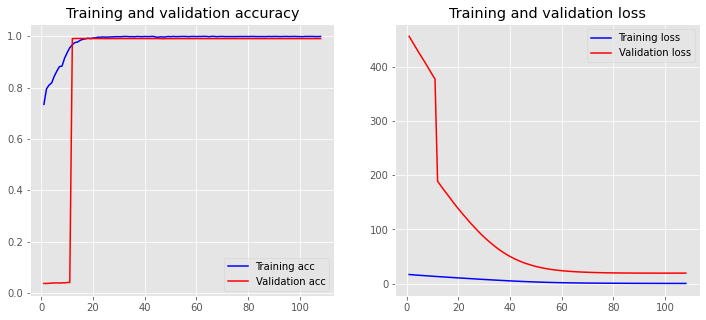

864/864 [==============================] - 71s 79ms/step
F1-score: 58.5%
Classification Report:
,precision,recall,f1-score,support
AD,0.8814436721691283,0.8814436721691283,0.8814436721691283,27624.0
problem,0.3299127442546393,0.4277746793084216,0.3725238508239375,12551.0
test,0.32809889742733045,0.32689747003994674,0.32749708187427046,9012.0
treatment,0.27621019932694796,0.11452184179456906,0.1619119878603945,9317.0
micro avg,0.5944836094465985,0.5765588677697251,0.5853840547013293,58504.0
macro avg,0.4539163782945115,0.43765941582801643,0.4358441481819327,58504.0
weighted avg,0.5814989153542365,0.5765588677697251,0.5723452164713091,58504.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 204, 100)          2839000   
       

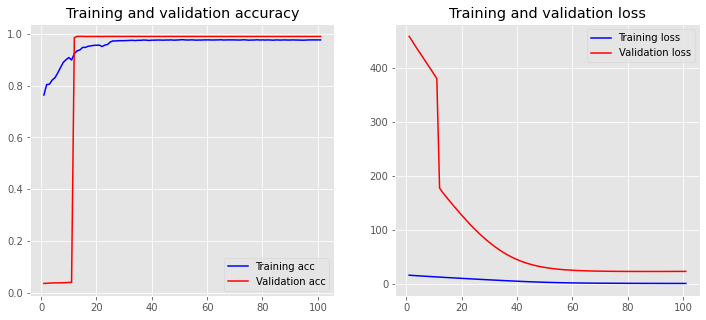

864/864 [==============================] - 71s 80ms/step
F1-score: 53.2%
Classification Report:
,precision,recall,f1-score,support
AD,0.859401955146636,0.8656240949898639,0.8625018034915597,27624.0
problem,0.28200662884107636,0.39996813002947973,0.33078545071165,12551.0
test,0.07920133111480865,0.026409232134931203,0.03961055171839893,9012.0
treatment,0.17897841533717657,0.1432864656005152,0.15915593705293274,9317.0
micro avg,0.543867781561447,0.5214173389853686,0.5324059933852855,58504.0
macro avg,0.34989708260992436,0.35882198068869753,0.34801343574363536,58504.0
weighted avg,0.5069890793665074,0.5214173389853686,0.50966197472209,58504.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 204, 100)          2839000   
        

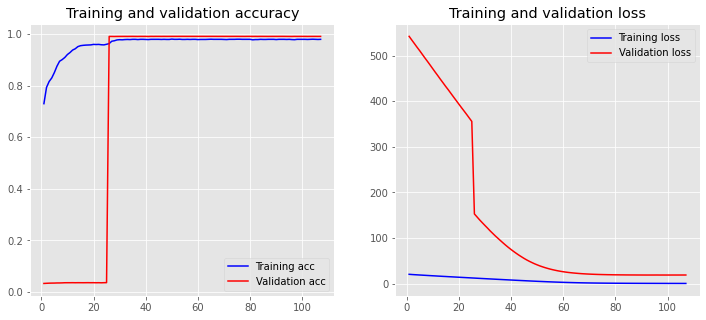

864/864 [==============================] - 71s 80ms/step
F1-score: 56.4%
Classification Report:
,precision,recall,f1-score,support
AD,0.864721772015127,0.8691355343179844,0.8669230352597086,27624.0
problem,0.30440150295222757,0.45183650705123096,0.36374715371540356,12551.0
test,0.31818778726198294,0.26886373723923657,0.29145365971011,9012.0
treatment,0.23267738359201773,0.1802082215305356,0.2031089336478558,9317.0
micro avg,0.551759056609937,0.5774306030356898,0.5643030151173474,58504.0
macro avg,0.4299971114553388,0.4425110000347469,0.4313081955832695,58504.0
weighted avg,0.5596708090973453,0.5774306030356898,0.564614706146602,58504.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 204, 100)          2839000   
            

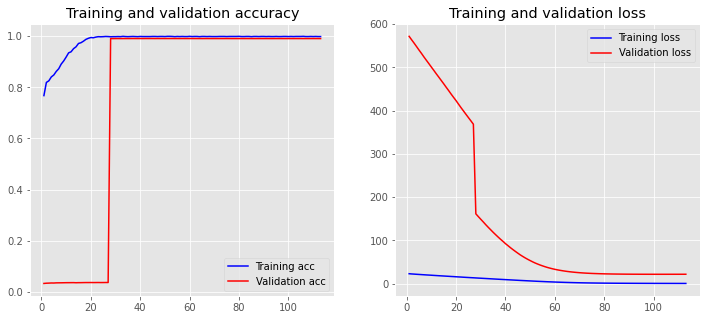

864/864 [==============================] - 72s 81ms/step
F1-score: 58.0%
Classification Report:
,precision,recall,f1-score,support
AD,0.880483567395396,0.8806110628439039,0.8805473105045972,27624.0
problem,0.3344078947368421,0.40498765038642337,0.36632914129220573,12551.0
test,0.30650664784092246,0.2890590324012428,0.29752726857403916,9012.0
treatment,0.25685364824968365,0.13072877535687452,0.17326979159257413,9317.0
micro avg,0.592698282473381,0.5680295364419526,0.5801017691777295,58504.0
macro avg,0.4445629395557111,0.4263466302471111,0.429418377990854,58504.0
weighted avg,0.5756012392940179,0.5680295364419526,0.5677852172568495,58504.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 204, 100)          2839000   
         

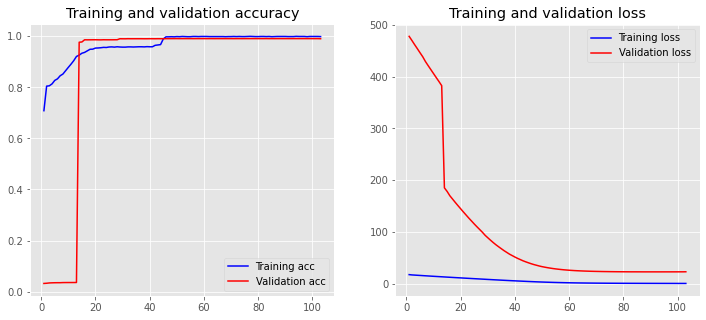

864/864 [==============================] - 72s 80ms/step
F1-score: 57.0%
Classification Report:
,precision,recall,f1-score,support
AD,0.8678056902917541,0.8678685201274254,0.8678371040723981,27624.0
problem,0.31428413365788893,0.4526332563142379,0.37097985437685704,12551.0
test,0.3174259569024894,0.3579671549045717,0.3364797913950457,9012.0
treatment,0.2310350786245032,0.14350112697220135,0.17703919491525427,9317.0
micro avg,0.5550184908843184,0.5848830849172706,0.5695595725556776,58504.0
macro avg,0.4326377148691589,0.4554925145796091,0.4380839861898888,58504.0
weighted avg,0.5628681987780205,0.5848830849172706,0.5693820999291919,58504.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 204, 100)          2839000   
        

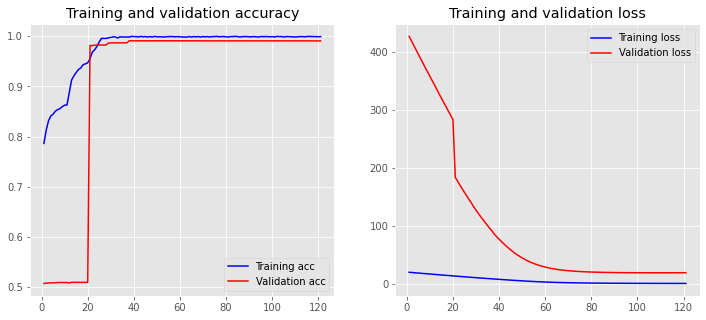

864/864 [==============================] - 71s 79ms/step
F1-score: 57.7%
Classification Report:
,precision,recall,f1-score,support
AD,0.882316742081448,0.8823486823052418,0.8823327119042879,27624.0
problem,0.28948876662081613,0.4024380527448012,0.3367445581519384,12551.0
test,0.3805080352514256,0.3257878384376387,0.3510282161645146,9012.0
treatment,0.24167763776565732,0.13791993130836105,0.17561842285089516,9317.0
micro avg,0.5790451932674767,0.5751059756597839,0.5770688620186948,58504.0
macro avg,0.44849779542983675,0.4371236261990107,0.436430977267909,58504.0
weighted avg,0.5758125967090157,0.5751059756597839,0.5708967406123585,58504.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 204, 100)          2839000   
                                                                 
 bidirectional_40 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_40 (TimeDi  (None, 204, 8)           1608      
 stributed)                                                      
                                                                 
 crf_40 (CRF)                (None, 204, 8)            64        
                                                                 
Total params: 3,001,472

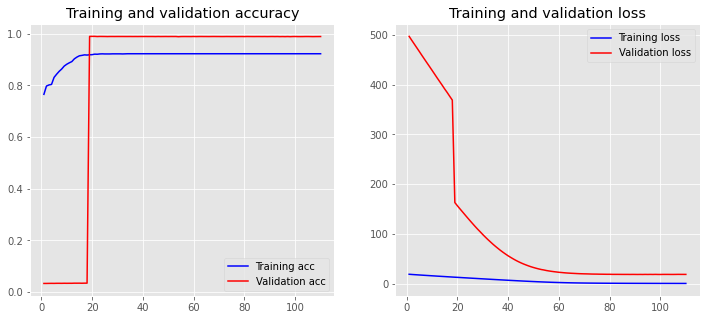

864/864 [==============================] - 71s 78ms/step


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


F1-score: 49.9%
Classification Report:
,precision,recall,f1-score,support
AD,0.8336311713795157,0.8612438459310744,0.8472125776756939,27624.0
problem,0.13864306784660768,0.17600191219823122,0.15510462013762114,12551.0
test,0.22829964328180738,0.19174434087882822,0.2084313370725529,9012.0
treatment,0.23208309290248125,0.21584200923043897,0.22366811255700142,9317.0
micro avg,0.4898856785161269,0.5083242171475455,0.4989346531331264,58504.0
macro avg,0.35816424385260304,0.36120802705964317,0.3586041618607173,58504.0
weighted avg,0.4954890466388381,0.5083242171475455,0.5010327045578435,58504.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 204, 100)          2839000   
                                                            

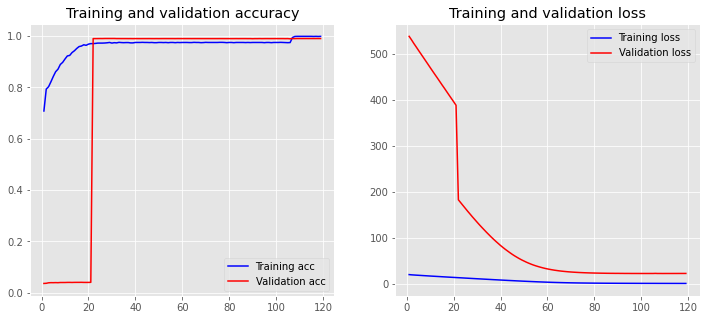

864/864 [==============================] - 69s 78ms/step
F1-score: 56.7%
Classification Report:
,precision,recall,f1-score,support
AD,0.8618380569732508,0.8619316536345207,0.8618848527628459,27624.0
problem,0.30797605369776865,0.4057843996494303,0.3501787678767877,12551.0
test,0.3227478222516264,0.32478916999556146,0.3237652784691112,9012.0
treatment,0.2464641173389209,0.10099817537834067,0.14328130947849257,9317.0
micro avg,0.5744158735166781,0.5601497333515657,0.5671931115053437,58504.0
macro avg,0.43475651256539166,0.4233758496644633,0.41977755214680934,58504.0
weighted avg,0.5619740785445124,0.5601497333515657,0.5547744690673657,58504.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 204, 100)          2839000   
       

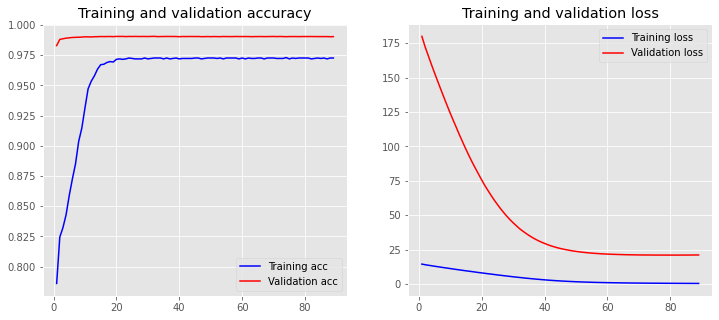

864/864 [==============================] - 70s 79ms/step
F1-score: 54.2%
Classification Report:
,precision,recall,f1-score,support
AD,0.8625825437840942,0.8700767448595425,0.8663134371395618,27624.0
problem,0.27417225537307915,0.4136722173531989,0.32977642276422764,12551.0
test,0.09517316607581129,0.03872614292055038,0.05505166022556985,9012.0
treatment,0.2679900744416873,0.18546742513684664,0.21921979067554706,9317.0
micro avg,0.550003513950383,0.5350745248188158,0.5424363195286779,58504.0
macro avg,0.374979509918668,0.3769856325675346,0.3675903277012266,58504.0
weighted avg,0.5234459227219975,0.5350745248188158,0.5231892284516269,58504.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 204, 100)          2839000   
        

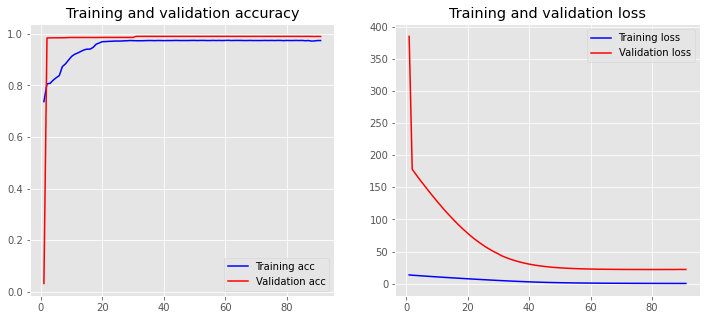

864/864 [==============================] - 71s 80ms/step
F1-score: 54.1%
Classification Report:
,precision,recall,f1-score,support
AD,0.866988159930903,0.8721039675644368,0.8695385392792045,27624.0
problem,0.28270264572572995,0.4273763046769182,0.3403013481363997,12551.0
test,0.15361091507880498,0.0724589436307146,0.09846942622332806,9012.0
treatment,0.1983053367028393,0.1431791349146721,0.16629269508850664,9317.0
micro avg,0.5445539410104089,0.5374333378914262,0.540970208958819,58504.0
macro avg,0.3754017643595693,0.3787795876966854,0.36865050218185974,58504.0
weighted avg,0.5252603963008587,0.5374333378914262,0.5252292208869982,58504.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 204, 100)          2839000   
          

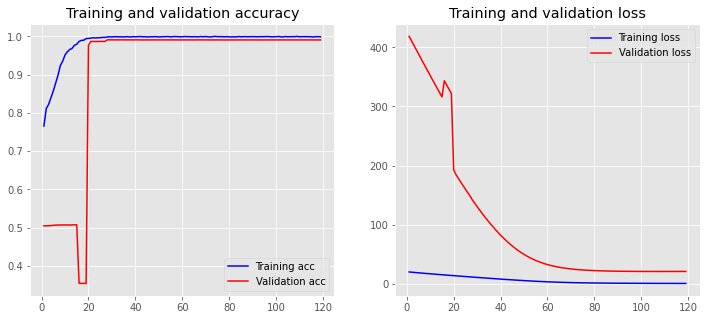

864/864 [==============================] - 71s 79ms/step
F1-score: 58.9%
Classification Report:
,precision,recall,f1-score,support
AD,0.882076154625742,0.8822038806834637,0.8821400130312025,27624.0
problem,0.3317349902073344,0.39136323798900485,0.3590905767965495,12551.0
test,0.37690851735015773,0.3314469596094097,0.3527188994509063,9012.0
treatment,0.25973568281938325,0.15820543093270367,0.19663820704375667,9317.0
micro avg,0.6021772106719014,0.5767639819499522,0.5891966928295166,58504.0
macro avg,0.46261383625065433,0.4408048773036455,0.44764692408060375,58504.0
weighted avg,0.5870835237361816,0.5767639819499522,0.5792076173633544,58504.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 204, 100)          2839000   
       

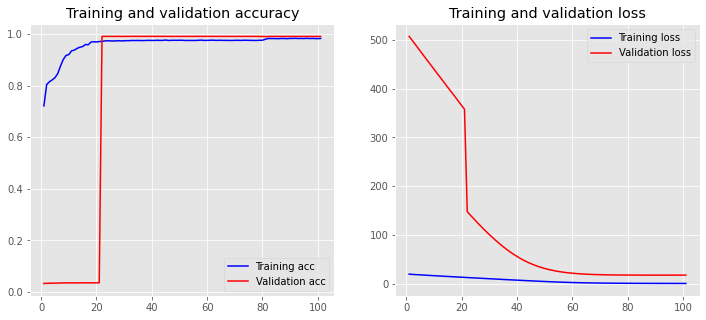

864/864 [==============================] - 70s 78ms/step
F1-score: 55.8%
Classification Report:
,precision,recall,f1-score,support
AD,0.8667148014440433,0.8690993339125398,0.8679054298315378,27624.0
problem,0.28346997888948894,0.4600430244602024,0.35078979343863914,12551.0
test,0.29946323804768443,0.26620062139369727,0.28185396228631854,9012.0
treatment,0.23920383863515193,0.14446710314478908,0.1801391862955032,9317.0
micro avg,0.5433257166934059,0.5730719267058663,0.5578025305504488,58504.0
macro avg,0.42221296425409216,0.43495252072780716,0.4201720929629997,58504.0
weighted avg,0.5542763955623833,0.5730719267058663,0.5571620230745636,58504.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 204, 100)          2839000   
    

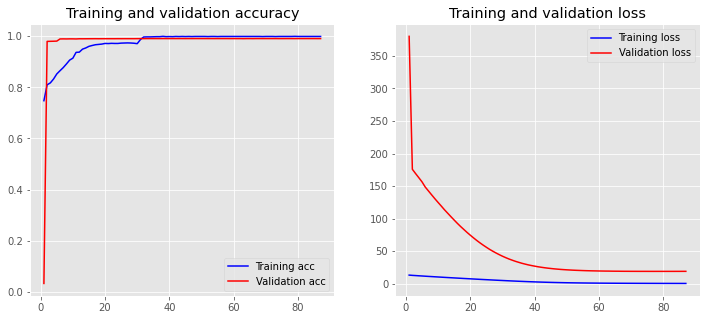

864/864 [==============================] - 71s 79ms/step
F1-score: 59.0%
Classification Report:
,precision,recall,f1-score,support
AD,0.8755792064871126,0.8755792064871126,0.8755792064871126,27624.0
problem,0.32556810968642885,0.4086526969962553,0.36240946829182125,12551.0
test,0.3489500792393027,0.39092321349312026,0.3687460749424325,9012.0
treatment,0.3305679642629228,0.16679188580015025,0.2217149379369382,9317.0
micro avg,0.5911989686291362,0.5878743333789143,0.5895319637638308,58504.0
macro avg,0.47016633991894174,0.46048675069415956,0.45711242191457613,58504.0
weighted avg,0.5896664361721696,0.5878743333789143,0.5832842017754393,58504.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 204, 100)          2839000   
      

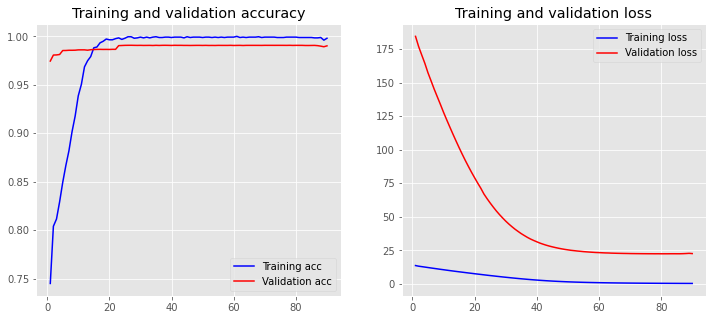

864/864 [==============================] - 70s 78ms/step
F1-score: 57.5%
Classification Report:
,precision,recall,f1-score,support
AD,0.882976798059869,0.8830726904141326,0.8830247416336356,27624.0
problem,0.29240620085374075,0.4147876663214087,0.3430077417229452,12551.0
test,0.32418788410886745,0.3277851753217932,0.3259766056058266,9012.0
treatment,0.27419354838709675,0.1733390576365783,0.21240218320510293,9317.0
micro avg,0.5654030082901725,0.5840455353480104,0.5745730933183114,58504.0
macro avg,0.4434411078523935,0.44974614742347824,0.44110281804187756,58504.0
weighted avg,0.5732528339674691,0.5840455353480104,0.5745661482957385,58504.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 204, 100)          2839000   
        

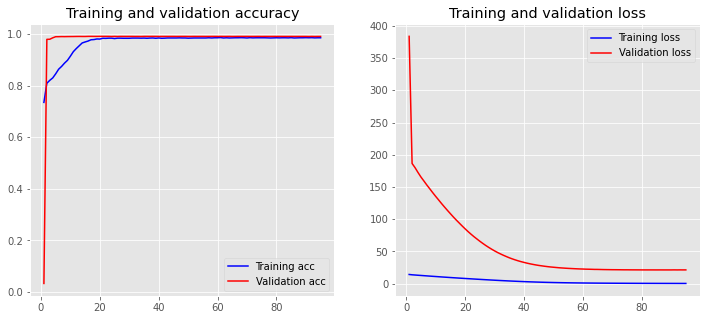

864/864 [==============================] - 71s 79ms/step
F1-score: 55.9%
Classification Report:
,precision,recall,f1-score,support
AD,0.8689486376561206,0.8739501882421084,0.8714422365405093,27624.0
problem,0.31259801359121797,0.42881045335033063,0.36159634506852995,12551.0
test,0.26672091131000814,0.18186861961828674,0.2162697103648479,9012.0
treatment,0.21132953957578893,0.17537834066759686,0.19168279664496451,9317.0
micro avg,0.5570426482327564,0.5605941474087242,0.5588127550455354,58504.0
macro avg,0.414899275533284,0.41500190046958063,0.4102477721547129,58504.0
weighted avg,0.5520973097249671,0.5605941474087242,0.5528860815550952,58504.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 204, 100)          2839000   
    

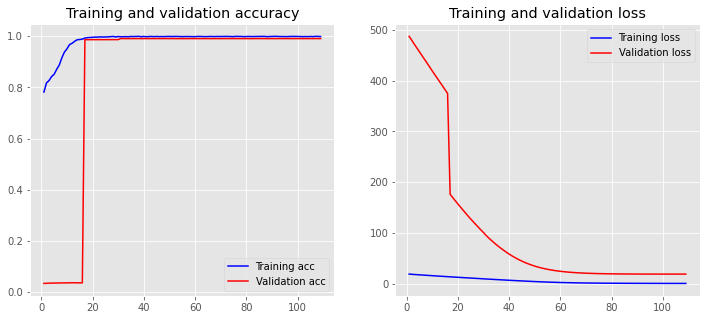

864/864 [==============================] - 72s 80ms/step
F1-score: 59.1%
Classification Report:
,precision,recall,f1-score,support
AD,0.884311880112937,0.8843759050101361,0.8843438914027149,27624.0
problem,0.3234401140095421,0.4159031152896184,0.3638898570930638,12551.0
test,0.3798283261802575,0.33388814913448733,0.35537970946025743,9012.0
treatment,0.27590069068508494,0.158634753676076,0.20144473217936484,9317.0
micro avg,0.5984327887244933,0.5834985642007384,0.5908713262020978,58504.0
macro avg,0.46587025274695537,0.44820048077757946,0.4512645475338502,58504.0
weighted avg,0.589383766200994,0.5834985642007384,0.5824531615591177,58504.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 204, 100)          2839000   
                                                                 
 bidirectional_50 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_50 (TimeDi  (None, 204, 8)           1608      
 stributed)                                                      
                                                                 
 crf_50 (CRF)                (None, 204, 8)            64        
                                                                 
Total params: 3,001,472

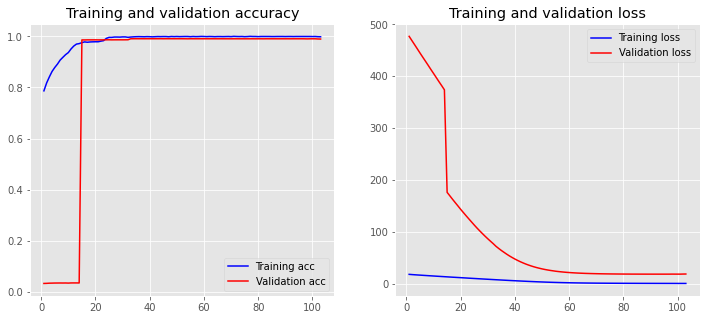

864/864 [==============================] - 71s 80ms/step


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


F1-score: 58.4%
Classification Report:
,precision,recall,f1-score,support
AD,0.8808006949974662,0.8808644656820156,0.8808325791855204,27624.0
problem,0.29928049337597074,0.4175762887419329,0.34866779762498745,12551.0
test,0.3738972809667674,0.34332001775410564,0.3579568461849945,9012.0
treatment,0.29718048981271866,0.15498551035741118,0.20372460496613992,9317.0
micro avg,0.5853926414058209,0.5830712429919321,0.5842296362266218,58504.0
macro avg,0.4627897397882307,0.4491865706338663,0.44779545699041057,58504.0
weighted avg,0.5850181319333622,0.5830712429919321,0.5782896543433053,58504.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 204, 100)          2839000   
                                                               

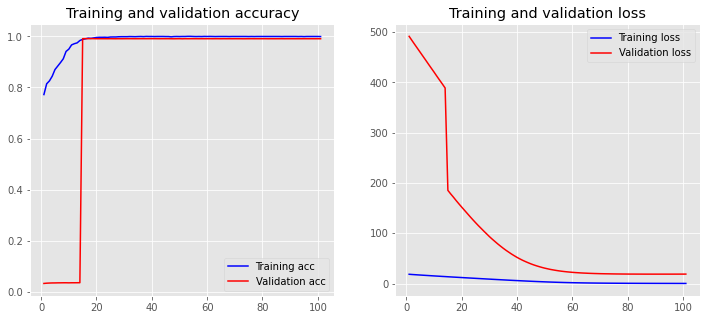

864/864 [==============================] - 71s 79ms/step
F1-score: 58.7%
Classification Report:
,precision,recall,f1-score,support
AD,0.8818780770344627,0.8818780770344627,0.8818780770344627,27624.0
problem,0.31072147168726644,0.4306429766552466,0.36098310291858676,12551.0
test,0.36350811192099697,0.343098091433644,0.3530083342847357,9012.0
treatment,0.3009688723974438,0.1567028013309005,0.20609824957651043,9317.0
micro avg,0.5878785802384542,0.5865923697524955,0.5872347707049965,58504.0
macro avg,0.4642691332600425,0.4530804866135635,0.4504919409535739,58504.0
weighted avg,0.5869842622710565,0.5865923697524955,0.5810410813723774,58504.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, 204, 100)          2839000   
          

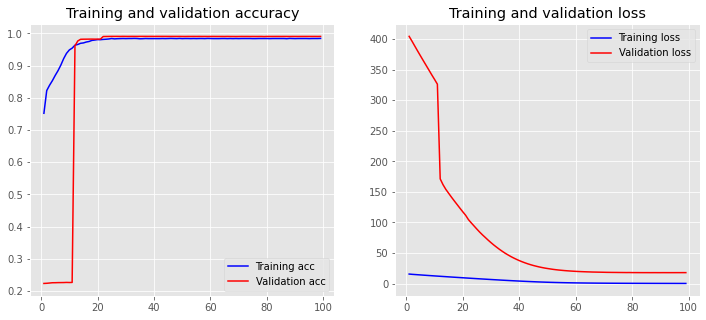

864/864 [==============================] - 73s 81ms/step
F1-score: 55.8%
Classification Report:
,precision,recall,f1-score,support
AD,0.8681970039874987,0.8748913987836664,0.8715313463514903,27624.0
problem,0.28075491759702287,0.42076328579396066,0.3367877299831,12551.0
test,0.26017614853606286,0.24256546826453618,0.2510623636154818,9012.0
treatment,0.2828241123038811,0.14704303960502307,0.1934891603700304,9317.0
micro avg,0.5510660678209474,0.5641494598659921,0.5575310185224287,58504.0
macro avg,0.42298804560611636,0.4213157981117966,0.41321765008002564,58504.0
weighted avg,0.5552886762247565,0.5641494598659921,0.5532530636999479,58504.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, 204, 100)          2839000   
         

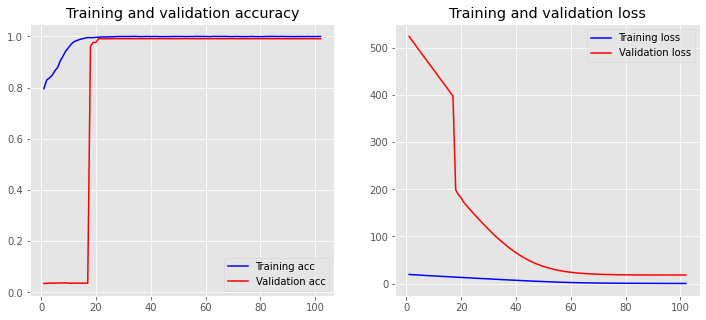

864/864 [==============================] - 70s 78ms/step
F1-score: 58.2%
Classification Report:
,precision,recall,f1-score,support
AD,0.8845931074428034,0.8845931074428034,0.8845931074428034,27624.0
problem,0.2966554407153641,0.4070591984702414,0.3431968562120042,12551.0
test,0.37404669717235717,0.35375055481580114,0.363615625891075,9012.0
treatment,0.24578203374373006,0.11570247933884298,0.15733780923885282,9317.0
micro avg,0.5854211756557873,0.5779262956379051,0.5816495927197034,58504.0
macro avg,0.4502693197685636,0.4402763350169222,0.43718584969618385,58504.0
weighted avg,0.5780832503713618,0.5779262956379051,0.5723759765405037,58504.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, 204, 100)          2839000   
        

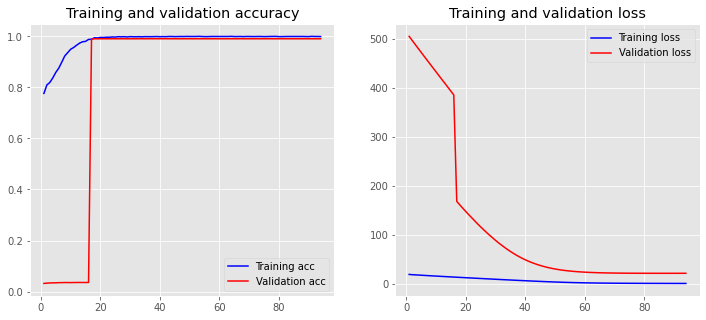

864/864 [==============================] - 71s 79ms/step
F1-score: 57.8%
Classification Report:
,precision,recall,f1-score,support
AD,0.8837647058823529,0.8837966985230234,0.8837807019131567,27624.0
problem,0.280424438002516,0.4084933471436539,0.3325549717843938,12551.0
test,0.3637679545707605,0.36251664447403464,0.3631412215861724,9012.0
treatment,0.27147766323024053,0.09327036599763873,0.1388400702987698,9317.0
micro avg,0.5797383370631778,0.5756358539587036,0.5776798119971868,58504.0
macro avg,0.4498586904214674,0.4370192640345877,0.4295792413956232,58504.0
weighted avg,0.5767188149796859,0.5756358539587036,0.5666904345758101,58504.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 204, 100)          2839000   
           

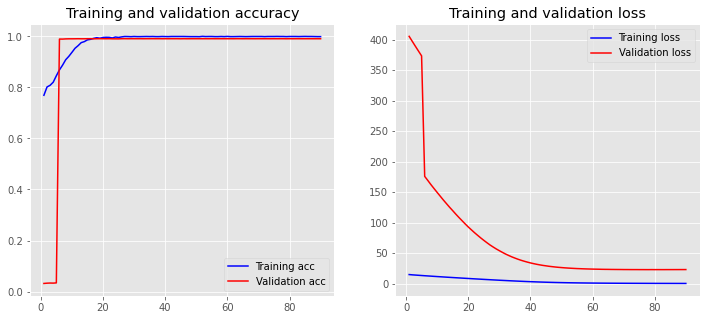

864/864 [==============================] - 71s 79ms/step
F1-score: 58.3%
Classification Report:
,precision,recall,f1-score,support
AD,0.8841949029829134,0.8841949029829134,0.8841949029829134,27624.0
problem,0.3043776040180355,0.4249063819615967,0.35468209630220804,12551.0
test,0.3771399150469816,0.3251220594762539,0.3492044574220845,9012.0
treatment,0.2579767125359141,0.1831061500482988,0.21418706842435653,9317.0
micro avg,0.5777882305508425,0.5878914262272665,0.582796045106794,58504.0
macro avg,0.45592228364596116,0.4543323736172657,0.4505671312828906,58504.0
weighted avg,0.5819704166062298,0.5878914262272665,0.5814854792405061,58504.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, 204, 100)          2839000   
           

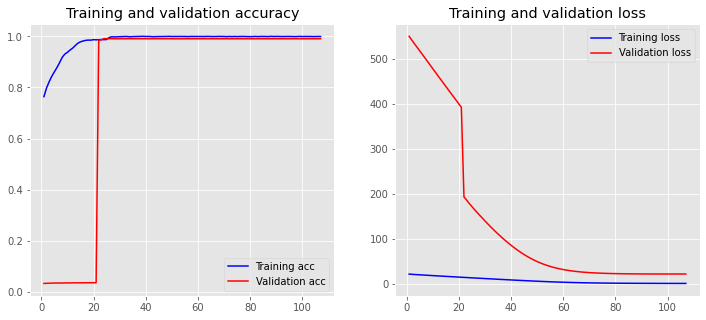

864/864 [==============================] - 71s 80ms/step
F1-score: 58.1%
Classification Report:
,precision,recall,f1-score,support
AD,0.876737619461338,0.876737619461338,0.876737619461338,27624.0
problem,0.30177646600211616,0.4317584256234563,0.35525108168349284,12551.0
test,0.3581065630002287,0.34753661784287615,0.3527424259488681,9012.0
treatment,0.2932776801405975,0.1432864656005152,0.19251568245727882,9317.0
micro avg,0.579238777832504,0.5829515930534664,0.5810892548324715,58504.0
macro avg,0.45747458215107006,0.4498297821320464,0.4443117023877445,58504.0
weighted avg,0.5805811725082143,0.5829515930534664,0.5751801531914943,58504.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_57 (Embedding)    (None, 204, 100)          2839000   
            

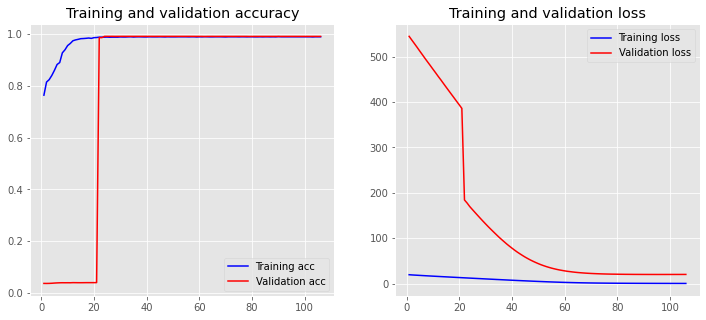

864/864 [==============================] - 70s 79ms/step
F1-score: 57.6%
Classification Report:
,precision,recall,f1-score,support
AD,0.8750722752240532,0.8765928178395598,0.8758318865740741,27624.0
problem,0.2981327564613458,0.41725758903673016,0.34777700302154935,12551.0
test,0.3643034545044028,0.3580781180648025,0.3611639619473979,9012.0
treatment,0.24184615384615385,0.12654287860899432,0.1661499436302142,9317.0
micro avg,0.574146614437605,0.5787296595104608,0.5764290274526496,58504.0
macro avg,0.4448386600089889,0.4446178508875217,0.4377306987933089,58504.0
weighted avg,0.5717770426725334,0.5787296595104608,0.5702474676862836,58504.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, 204, 100)          2839000   
          

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

In [ ]:
number_of_training_models = 2
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)